### Library Import

In [23]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import xgboost as xgb
from xgboost import XGBClassifier

# from google.colab import drive

import matplotlib.pyplot as plt
import seaborn as sns


### Data Load

In [2]:
# drive.mount('/content/drive')

# 기본 경로 설정
base_path = "/data/ephemeral/home/JihoonRyu00/data/"

In [35]:
# LightGBM과 XGBoost 피처 중요도 CSV 파일 로드
lgb_importances = pd.read_csv(os.path.join(base_path, 'top_50_important_features_data_LGBM.csv'))
xgb_importances = pd.read_csv(os.path.join(base_path, 'top_50_important_features_data_XGB.csv'))






# 상위 20개 column 선택
lgb_top_20 = lgb_importances.iloc[:, :20]
xgb_top_20 = xgb_importances.iloc[:, :20]

# 두 데이터프레임을 합침 (중복된 열 포함)
merged_df = pd.concat([lgb_top_20, xgb_top_20], axis=1)

# 중복된 열(동일한 feature 이름을 가진 열) 제거
merged_df_unique = merged_df.loc[:, ~merged_df.columns.duplicated()]

# 마지막에 '_type', 'target', 'ID' 열 추가 (원본 CSV 파일에서 가져옴)
common_columns = ['_type', 'target', 'ID']

# 원본에서 해당 열들을 가져와 합치기
final_df = pd.concat([merged_df_unique, lgb_importances[common_columns]], axis=1)

# 결과 확인
print(f"최종 데이터프레임 크기: {final_df.shape}")

# 합쳐진 데이터프레임 확인
final_df

final_df.to_csv(os.path.join(base_path, 'top_20_important_features_data_LGBM+XGB.csv'), index=False)




# # 두 데이터프레임을 합침
# merged_df = pd.concat([lgb_importances, xgb_importances], axis=1)

# # 중복된 열(동일한 피처 이름을 가진 열) 찾기
# duplicate_columns = merged_df.columns[merged_df.columns.duplicated()]

# # 중복된 열 제거
# merged_df_unique = merged_df.loc[:, ~merged_df.columns.duplicated()]

# # 결과 확인
# print(f"중복된 열: {duplicate_columns}")
# print(f"중복된 열을 제거한 데이터프레임 크기: {merged_df_unique.shape}")

최종 데이터프레임 크기: (10504, 42)


In [14]:
merged_df_unique.to_csv(os.path.join(base_path, 'top_50_important_features_data_LGBM+XGB.csv'), index=False)

In [36]:
df=final_df

In [37]:
# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
# test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

train_df

,hourly_market-data_open-interest_binance_all_symbol_open_interest_shift_6h_rolling_std_2h,hourly_network-data_block-bytes_block_bytes_shift_24h_rolling_std_2h,hourly_market-data_taker-buy-sell-stats_bitmex_taker_sell_volume,hourly_market-data_open-interest_binance_btc_usd_open_interest_shift_3h_rolling_std_2h,hourly_market-data_open-interest_htx_global_all_symbol_open_interest_shift_24h_rolling_mean_168h,hourly_network-data_tokens-transferred_tokens_transferred_total_shift_4h,hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio,hourly_market-data_open-interest_bitmex_btc_usd_open_interest_shift_3h_rolling_std_2h,hourly_market-data_taker-buy-sell-stats_binance_taker_sell_ratio,hourly_market-data_taker-buy-sell-stats_binance_taker_buy_sell_ratio_shift_1h_rolling_std_2h,...,hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume_rolling_mean_2h,hourly_market-data_open-interest_huobi_global_all_symbol_open_interest_shift_12h_rolling_mean_168h,hourly_market-data_taker-buy-sell-stats_binance_taker_sell_volume_rolling_mean_2h,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_sell_ratio_rolling_mean_7h,hourly_market-data_open-interest_htx_global_all_symbol_open_interest_shift_2h_rolling_mean_168h,hourly_market-data_liquidations_bybit_btc_usdt_short_liquidations_usd_shift_3h_rolling_mean_4h,hourly_market-data_liquidations_bybit_btc_usdt_liquidation_diff_rolling_sum_168h,hourly_market-data_liquidations_binance_all_symbol_liquidation_diff_rolling_mean_2h,target,ID
0,-9.990000e+02,-999.000000,1533800.0,-9.990000e+02,-9.990000e+02,-999.000000,0.475003,-9.990000e+02,0.528099,-999.000000,...,-9.990000e+02,-9.990000e+02,-9.990000e+02,-999.000000,-9.990000e+02,-999.00000,-999.000000,-999.000000,2.0,2023-01-01 00:00:00
1,-9.990000e+02,-999.000000,403600.0,-9.990000e+02,-9.990000e+02,-999.000000,0.623454,-9.990000e+02,0.398865,-999.000000,...,3.769333e+07,-9.990000e+02,3.377442e+07,-999.000000,-9.990000e+02,-999.00000,-999.000000,-0.350000,1.0,2023-01-01 01:00:00
2,-9.990000e+02,-999.000000,1005200.0,-9.990000e+02,-9.990000e+02,-999.000000,0.506785,-9.990000e+02,0.508885,0.433834,...,2.371062e+07,-9.990000e+02,2.042513e+07,-999.000000,-9.990000e+02,-999.00000,-999.000000,-0.356000,1.0,2023-01-01 02:00:00
3,-9.990000e+02,-999.000000,1528900.0,-9.990000e+02,-9.990000e+02,-999.000000,0.466518,-9.990000e+02,0.552471,0.383279,...,2.805884e+07,-9.990000e+02,2.438439e+07,-999.000000,-9.990000e+02,-999.00000,-999.000000,0.296500,1.0,2023-01-01 03:00:00
4,-9.990000e+02,-999.000000,1832400.0,1.456640e+04,-9.990000e+02,33057.024011,0.491559,1.534422e+04,0.497611,0.109621,...,3.232269e+07,-9.990000e+02,2.744900e+07,-999.000000,-9.990000e+02,-999.00000,-999.000000,0.477000,2.0,2023-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8.314182e+06,114482.984180,2767300.0,8.522758e+05,1.345010e+08,37948.678803,0.526526,1.019012e+06,0.476835,0.045632,...,1.063953e+08,1.346663e+08,9.215459e+07,1.170481,1.348628e+08,3508.26790,-174.408546,-13.838750,1.0,2023-12-31 19:00:00
8756,7.551819e+06,8563.315658,3497500.0,1.220254e+06,1.345169e+08,50949.684366,0.520872,8.223652e+04,0.478363,0.137328,...,1.054730e+08,1.346680e+08,8.827203e+07,1.191248,1.348869e+08,3508.26790,-209.719546,-18.216352,1.0,2023-12-31 20:00:00
8757,1.598130e+07,12732.619271,2728200.0,2.610143e+06,1.345326e+08,41706.377979,0.514914,1.170898e+06,0.482815,0.004738,...,1.036873e+08,1.346864e+08,8.722402e+07,1.143912,1.349100e+08,3830.51945,-209.799546,-19.024352,0.0,2023-12-31 21:00:00
8758,2.382480e+06,58878.041631,6704900.0,2.358908e+05,1.345500e+08,38495.449786,0.401345,2.525078e+05,0.583514,0.013630,...,2.264070e+08,1.346967e+08,1.856363e+08,1.101052,1.349276e+08,3830.51945,-211.872546,13.937420,2.0,2023-12-31 22:00:00


In [39]:
# df=top_50_data
# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
# _target = df["target"]

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

In [42]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# train_test_split으로 valid set, train set 분리
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.drop(["target", "ID"], axis=1),
    train_df["target"].astype(int),
    test_size=0.2,
    random_state=42,
)

# LightGBM 모델 정의
lgb_model = lgb.LGBMClassifier(
    learning_rate=0.05, 
    num_leaves=31, 
    n_estimators=500, 
    objective='multiclass', 
    num_class=4
)

# XGBoost 모델 정의
xgb_model = XGBClassifier(
    learning_rate=0.05,
    n_estimators=500,
    max_depth=5,
    objective='multi:softprob',  # 다중 클래스 분류
    num_class=4,
    eval_metric='mlogloss'
)

# 앙상블 모델 정의 (soft voting)
ensemble_model = VotingClassifier(
    estimators=[('lgb', lgb_model), ('xgb', xgb_model)], 
    voting='soft'  # soft는 각 모델의 예측 확률을 기반으로, hard는 다수결
)

# 앙상블 모델 학습  
ensemble_model.fit(x_train, y_train)

# 검증 데이터에 대한 예측
y_valid_pred = ensemble_model.predict(x_valid)

# 성능 평가 (정확도)
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f'앙상블 모델 정확도: {accuracy:.4f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9945
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 39
[LightGBM] [Info] Start training from score -2.472992
[LightGBM] [Info] Start training from score -0.894135
[LightGBM] [Info] Start training from score -0.873416
[LightGBM] [Info] Start training from score -2.417056
앙상블 모델 정확도: 0.4418


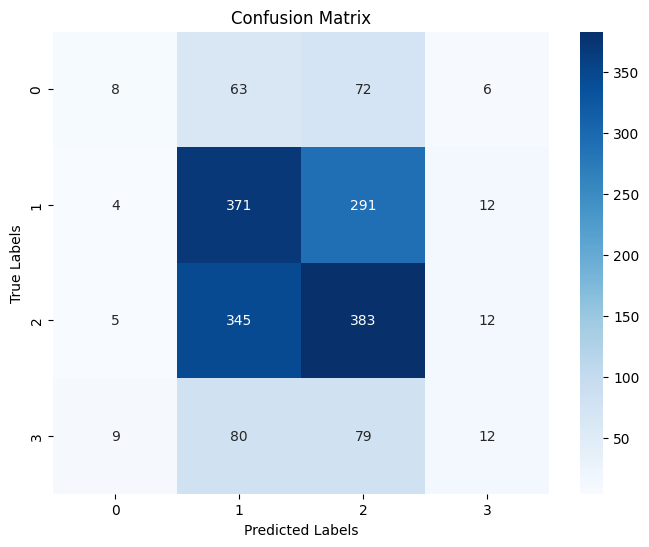

In [43]:
# 혼동행렬 계산
conf_matrix = confusion_matrix(y_valid, y_valid_pred)

# 혼동행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_valid), yticklabels=np.unique(y_valid))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [44]:
# 전체 train 데이터로 학습 (검증 데이터 나누지 않음)
X_train = train_df.drop(columns=["target", "ID"])
y_train = train_df["target"].astype(int)

# LightGBM 모델 정의
lgb_model = lgb.LGBMClassifier(
    learning_rate=0.05, 
    num_leaves=31, 
    n_estimators=500, 
    objective='multiclass', 
    num_class=4
)

# XGBoost 모델 정의
xgb_model = XGBClassifier(
    learning_rate=0.05,
    n_estimators=500,
    max_depth=5,
    objective='multi:softprob',  # 다중 클래스 분류
    num_class=4,
    eval_metric='mlogloss'
)

# 앙상블 모델 정의 (soft voting)
ensemble_model = VotingClassifier(
    estimators=[('lgb', lgb_model), ('xgb', xgb_model)], 
    voting='soft'  # soft는 각 모델의 예측 확률을 기반으로, hard는 다수결
)

# 앙상블 모델 학습  
ensemble_model.fit(X_train, y_train)



# 최종적으로 test_df에 대해 예측
y_test_pred = ensemble_model.predict(test_df.drop(columns=["target", "ID"], axis = 1))
# y_test_pred_class = np.argmax(y_test_pred, axis = 1)

# output file 할당후 save
submission_df = submission_df.assign(target = y_test_pred_class)
submission_df.to_csv("output.csv", index=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9945
[LightGBM] [Info] Number of data points in the train set: 8760, number of used features: 39
[LightGBM] [Info] Start training from score -2.471301
[LightGBM] [Info] Start training from score -0.904940
[LightGBM] [Info] Start training from score -0.869732
[LightGBM] [Info] Start training from score -2.387109


AxisError: axis 1 is out of bounds for array of dimension 1